In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Report notebook

In [34]:
import pandas as pd

df = pd.read_csv('datasets/tmdb-15000-movies.csv', lineterminator='\n')

In [35]:
from tmdb15k.datapoints import (
    Genres, Keywords, OriginalLanguage, Popularity, ReleaseDate, VoteAverage, 
    VoteCount
)

# df = df[df['popularity'] <= 100] # Remove outliers.
# df = df[df['popularity'] <= 50] # Remove outliers.
# df = df[df['vote_count'] >= 100] # These may be too opinionated.
# df = df[df['vote_count'] <= 2000]

# release_date = ReleaseDate(df)
# df = df[release_date.series_year >= 1980] # Remove old movies.

release_date = ReleaseDate(df)
popularity = Popularity(df)
vote_average = VoteAverage(df)
vote_count = VoteCount(df)
genres = Genres(df)
keywords = Keywords(df)
original_language = OriginalLanguage(df)

/home/cezar/code/cezarmathe/bigdata-tmdb-1500/tmdb15k/datapoints.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df.fillna(0, inplace=True)
/home/cezar/code/cezarmathe/bigdata-tmdb-1500/tmdb15k/ops.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[dst] = (df[src] - df[src].min()) / (df[src].max() - df[src].min())
/home/cezar/code/cezarmathe/bigdata-tmdb-1500/tmdb15k/ops.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [36]:
def describe_column(df: pd.DataFrame | pd.Series, name: str):
    print(f'{name}:')
    print(df.describe())
    print()


describe_column(vote_average.df, 'vote_average')
describe_column(vote_count.df, 'vote_count')
describe_column(popularity.df, 'popularity')
describe_column(release_date.df, 'release_date')

vote_average:
       vote_average  vote_average_min_max  vote_average_z_score
count  15871.000000          15871.000000          1.587100e+04
mean       5.603201              0.560320          2.292218e-16
std        2.555917              0.255592          1.000000e+00
min        0.000000              0.000000         -2.192247e+00
25%        5.700000              0.570000          3.787260e-02
50%        6.400000              0.640000          3.117470e-01
75%        7.100000              0.710000          5.856213e-01
max       10.000000              1.000000          1.720244e+00

vote_count:
         vote_count  vote_count_log10  vote_count_log10_min_max  \
count  15871.000000      15871.000000              15871.000000   
mean    1035.291475          2.017726                  0.445907   
std     2366.743281          1.262976                  0.279111   
min        0.000000          0.000000                  0.000000   
25%        3.000000          0.602060                  0.13305

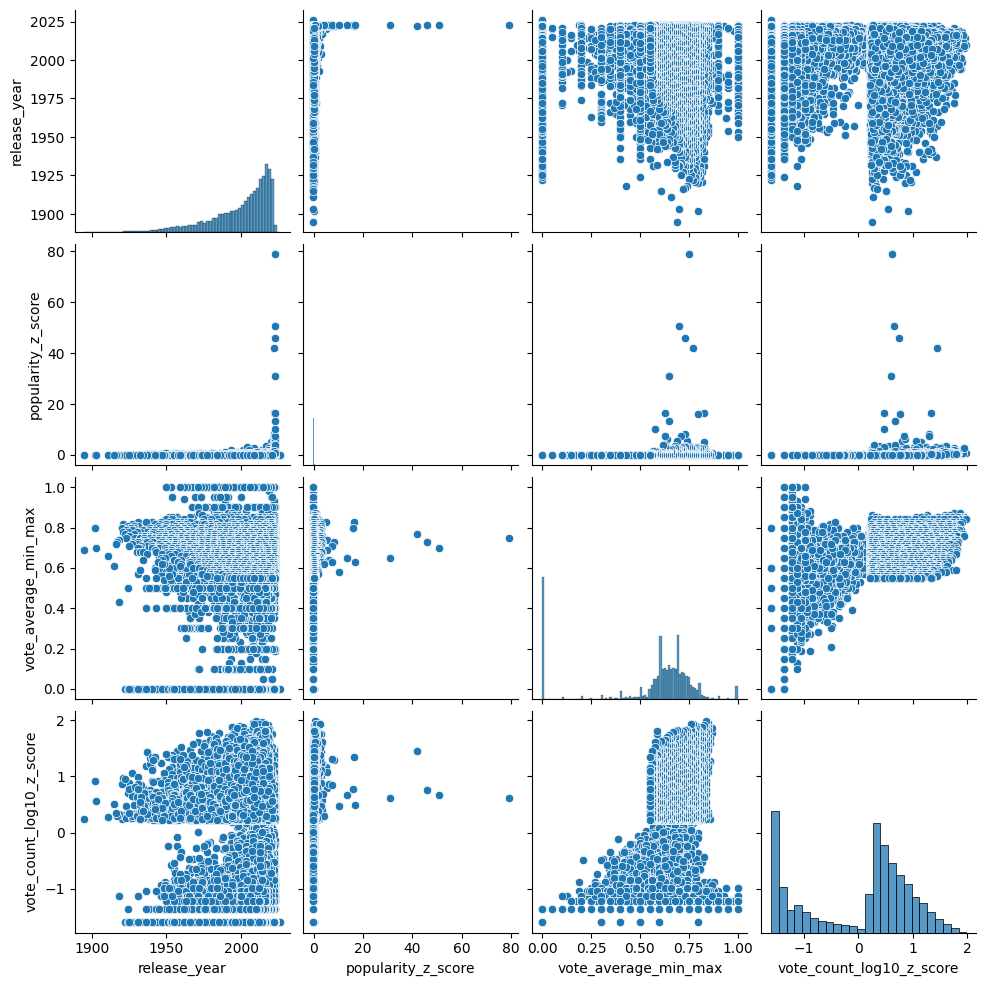

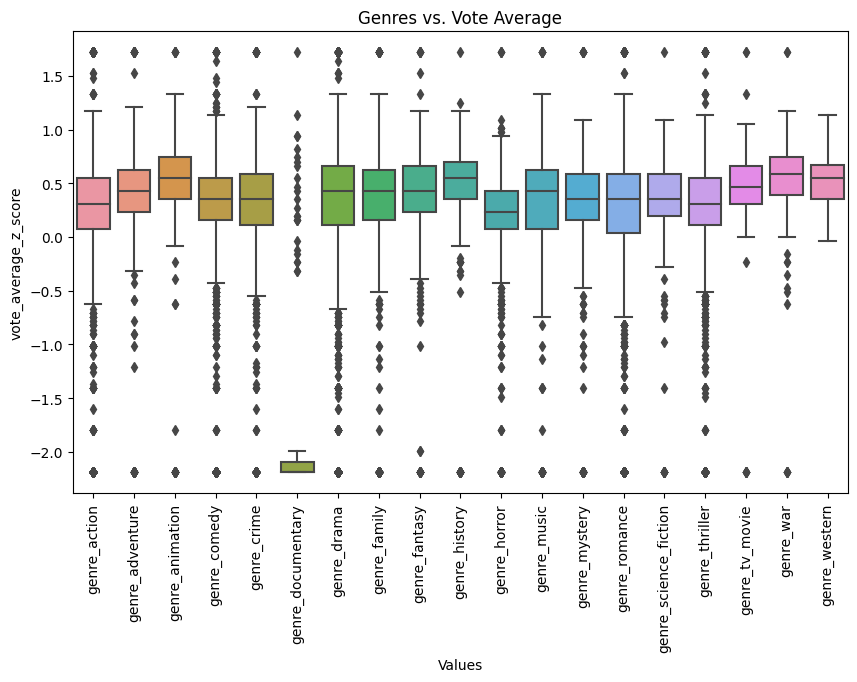

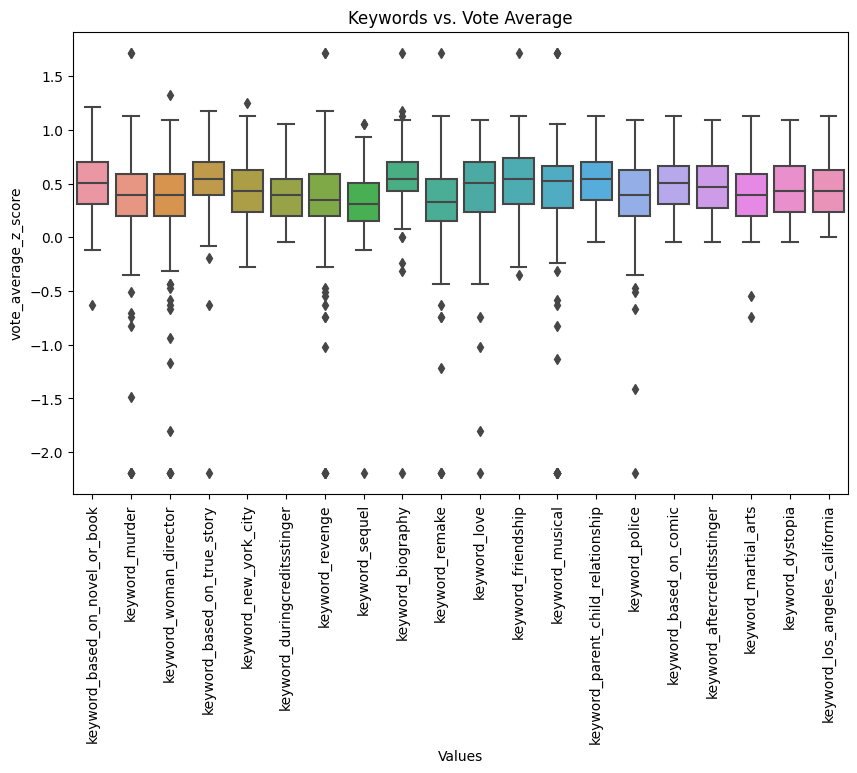

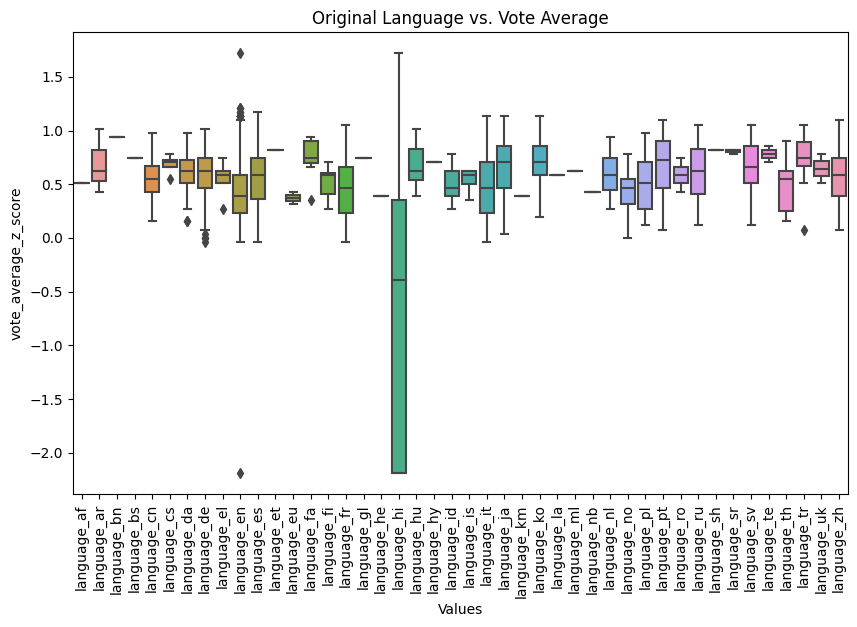

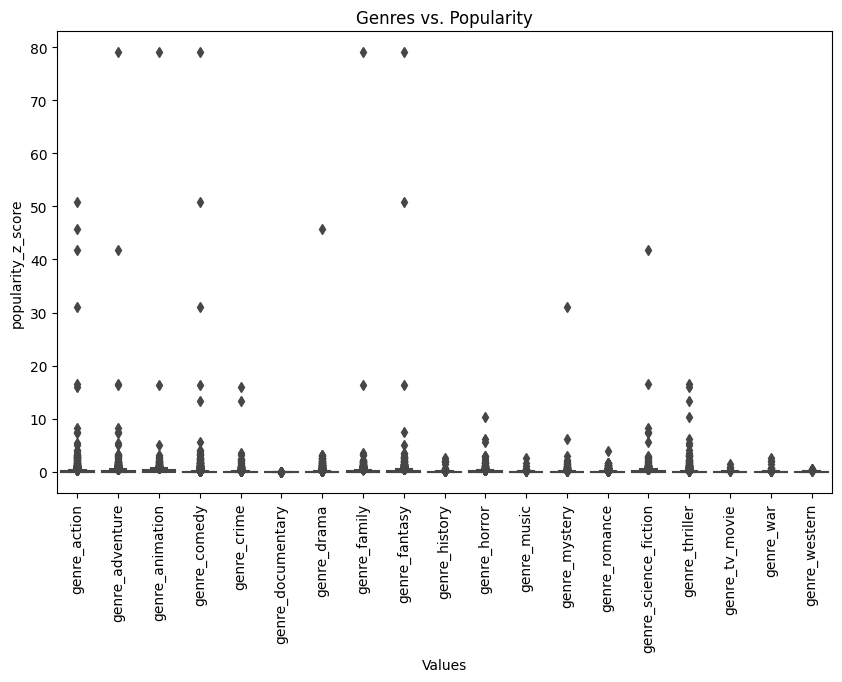

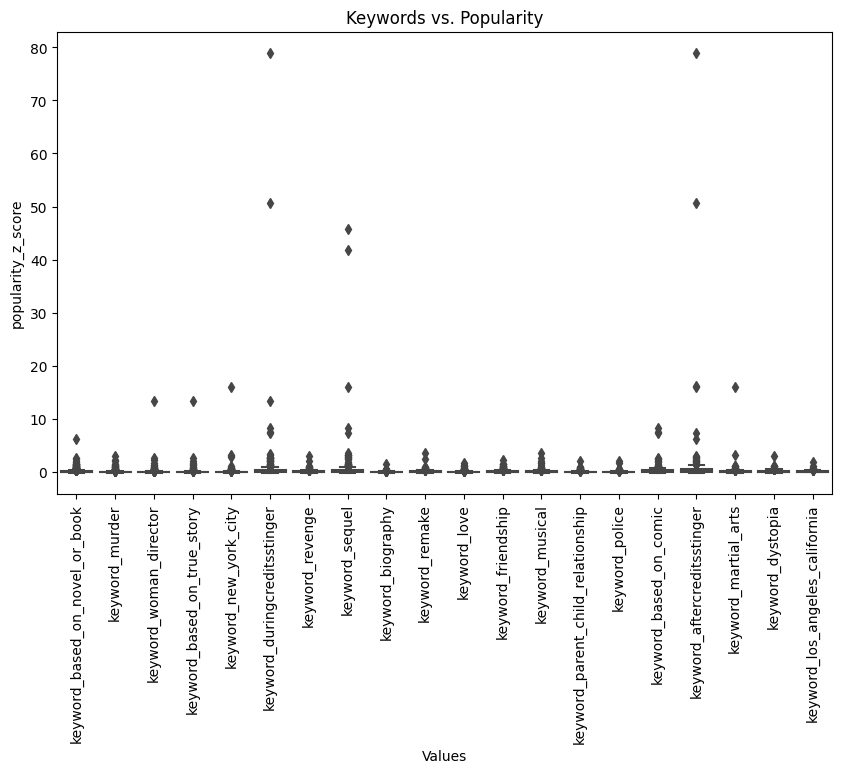

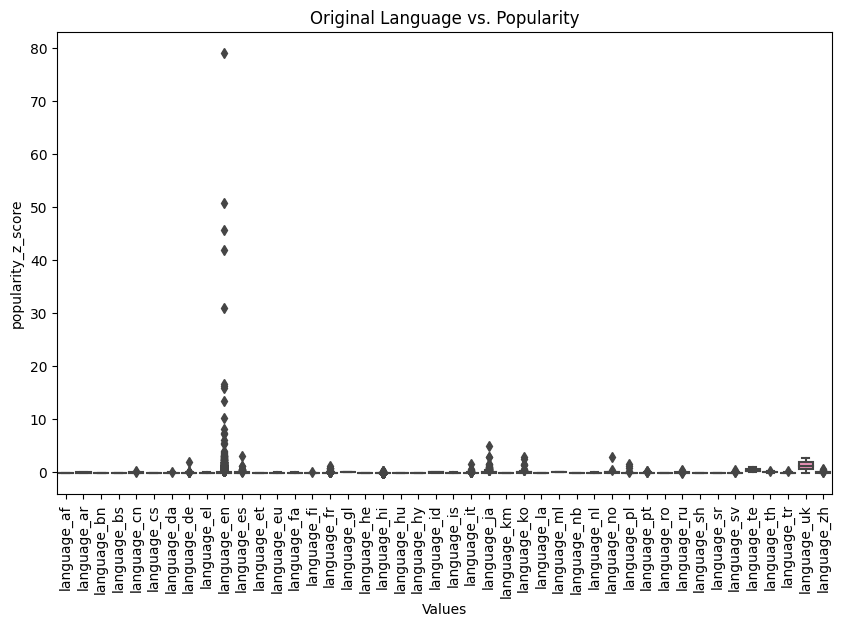

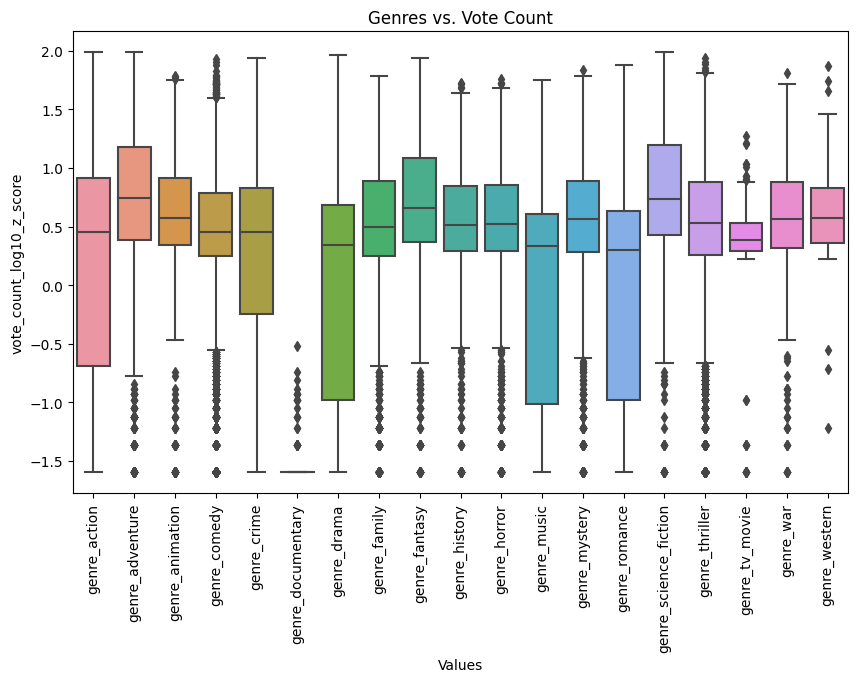

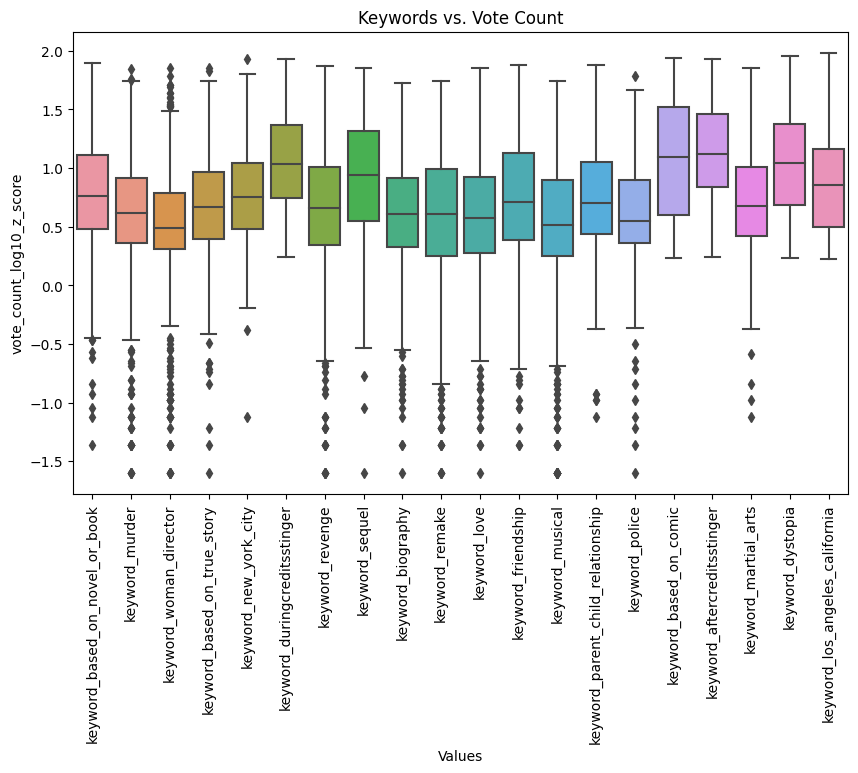

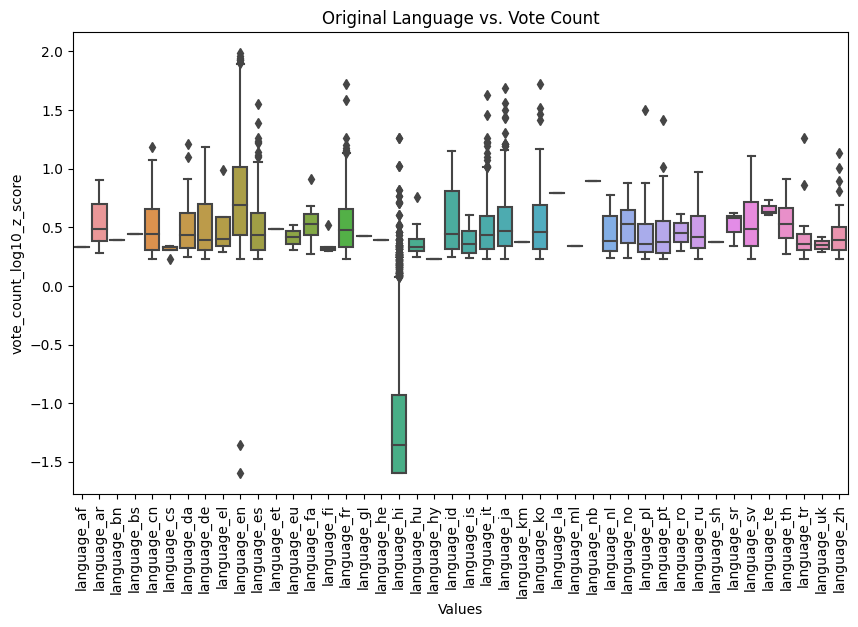

In [37]:
import seaborn as sns

import tmdb15k.plots as plots

# Plot various relationships to see if there are any obvious correlations.
df_pairplot = pd.concat([
    release_date.series_year,
    # popularity.df_min_max,
    popularity.df_z_score,
    vote_average.df_min_max,
    # vote_average.df_z_score,
    # vote_count.df_log10_min_max,
    vote_count.df_log10_z_score,
], axis=1)
sns.pairplot(df_pairplot)

plots.box(vote_average.df_z_score, genres.df, 'Genres vs. Vote Average')
plots.box(vote_average.df_z_score, keywords.df[keywords.columns_top_20], 'Keywords vs. Vote Average')
plots.box(vote_average.df_z_score, original_language.df, 'Original Language vs. Vote Average')
plots.box(popularity.df_z_score, genres.df, 'Genres vs. Popularity')
plots.box(popularity.df_z_score, keywords.df[keywords.columns_top_20], 'Keywords vs. Popularity')
plots.box(popularity.df_z_score, original_language.df, 'Original Language vs. Popularity')
plots.box(vote_count.df_log10_z_score, genres.df, 'Genres vs. Vote Count')
plots.box(vote_count.df_log10_z_score, keywords.df[keywords.columns_top_20], 'Keywords vs. Vote Count')
plots.box(vote_count.df_log10_z_score, original_language.df, 'Original Language vs. Vote Count')

In [38]:
parameters: dict[str, pd.DataFrame | pd.Series] = {
    'G': genres.df,
    'K20': keywords.df[keywords.columns_top_20],
    'K50': keywords.df[keywords.columns_top_50],
    'K100': keywords.df[keywords.columns_top_100],
    'L': original_language.df,
    'P': popularity.df_z_score,
    'Ry': release_date.series_year,
    'Va': vote_average.df_min_max,
    'Vc': vote_count.df_log10_z_score,
}
outputs: dict[str, pd.DataFrame | pd.Series] = {
    'Va': vote_average.df_min_max,
    'Vc': vote_count.df_log10_z_score,
    'P': popularity.df_z_score,
}

In [39]:
from tmdb15k.workflows import Analysis 

def create_analysis(output_name: str, parameter_names: list[str]) -> Analysis:
    X = []
    for name in parameter_names:
        X.append(parameters[name])
    y = outputs[output_name]
    return Analysis(parameter_names, X, y)

In [40]:
import tmdb15k.workflows as workflows

va_result_columns = ['G', 'K20', 'K50', 'K100', 'P', 'Vc'] + workflows.model_columns()

va_results = [
    # No keywords
    create_analysis('Va', ['G', 'P', 'Vc']),
    create_analysis('Va', ['G', 'P']),
    create_analysis('Va', ['G', 'Vc']),
    create_analysis('Va', ['G']),
    create_analysis('Va', ['P', 'Vc']),
    create_analysis('Va', ['P']),
    create_analysis('Va', ['Vc']),
    # K20
    create_analysis('Va', ['G', 'K20', 'P', 'Vc']),
    create_analysis('Va', ['G', 'K20', 'P']),
    create_analysis('Va', ['G', 'K20', 'Vc']),
    create_analysis('Va', ['G', 'K20']),
    create_analysis('Va', ['K20', 'P', 'Vc']),
    create_analysis('Va', ['K20', 'P']),
    create_analysis('Va', ['K20', 'Vc']),
    create_analysis('Va', ['K20']),
    # K50
    create_analysis('Va', ['G', 'K50', 'P', 'Vc']),
    create_analysis('Va', ['G', 'K50', 'P']),
    create_analysis('Va', ['G', 'K50', 'Vc']),
    create_analysis('Va', ['G', 'K50']),
    create_analysis('Va', ['K50', 'P', 'Vc']),
    create_analysis('Va', ['K50', 'P']),
    create_analysis('Va', ['K50', 'Vc']),
    create_analysis('Va', ['K50']),
    # K100
    create_analysis('Va', ['G', 'K100', 'P', 'Vc']),
    create_analysis('Va', ['G', 'K100', 'P']),
    create_analysis('Va', ['G', 'K100', 'Vc']),
    create_analysis('Va', ['G', 'K100']),
    create_analysis('Va', ['K100', 'P', 'Vc']),
    create_analysis('Va', ['K100', 'P']),
    create_analysis('Va', ['K100', 'Vc']),
    create_analysis('Va', ['K100']),
]

va_results_df = pd.DataFrame(columns=va_result_columns)

for analysis in va_results:
    va_results_df = pd.concat([va_results_df, analysis.summary()], axis=0)
    va_results_df = va_results_df.reset_index(drop=True)
    va_results_df = va_results_df.fillna('')

print('Vote Average Results:')
print(va_results_df)

va_results_df.to_csv('data/va_results.csv', index=False)

Vote Average Results:
    G K20 K50 K100  P Vc         L        DT        RF        GB       XGB
0   X               X  X  0.178331  0.135622  0.107839  0.098939  0.106138
1   X               X     0.228436  0.217059  0.179848  0.173112  0.177392
2   X                  X  0.178338  0.120323  0.108188  0.098918  0.101460
3   X                     0.228922  0.219310  0.218349  0.222812  0.218598
4                   X  X  0.182966  0.136952  0.114399  0.101971  0.107839
5                   X     0.253756  0.204806  0.189410  0.174427  0.176726
6                      X  0.182983  0.107434  0.105480  0.102004  0.102694
7   X   X           X  X  0.177730  0.133896  0.106875  0.098926  0.104490
8   X   X           X     0.223277  0.216257  0.178651  0.173075  0.173878
9   X   X              X  0.177729  0.120213  0.106891  0.098853  0.100275
10  X   X                 0.223633  0.216658  0.213308  0.220337  0.212372
11      X           X  X  0.181821  0.136891  0.113213  0.101133  0.105033
12 

In [41]:
import tmdb15k.workflows as workflows

va_result_columns = ['G', 'K20', 'K50', 'K100', 'Va', 'Vc'] + workflows.model_columns()

p_results = [
    # No keywords
    create_analysis('P', ['G', 'Va', 'Vc']),
    create_analysis('P', ['G', 'Va']),
    create_analysis('P', ['G', 'Vc']),
    create_analysis('P', ['G']),
    create_analysis('P', ['Va', 'Vc']),
    create_analysis('P', ['Va']),
    create_analysis('P', ['Vc']),
    # K20
    create_analysis('P', ['G', 'K20', 'Va', 'Vc']),
    create_analysis('P', ['G', 'K20', 'Va']),
    create_analysis('P', ['G', 'K20', 'Vc']),
    create_analysis('P', ['G', 'K20']),
    create_analysis('P', ['K20', 'Va', 'Vc']),
    create_analysis('P', ['K20', 'Va']),
    create_analysis('P', ['K20', 'Vc']),
    create_analysis('P', ['K20']),
    # P50
    create_analysis('P', ['G', 'K50', 'Va', 'Vc']),
    create_analysis('P', ['G', 'K50', 'Va']),
    create_analysis('P', ['G', 'K50', 'Vc']),
    create_analysis('P', ['G', 'K50']),
    create_analysis('P', ['K50', 'Va', 'Vc']),
    create_analysis('P', ['K50', 'Va']),
    create_analysis('P', ['K50', 'Vc']),
    create_analysis('P', ['K50']),
    # K100
    create_analysis('P', ['G', 'K100', 'Va', 'Vc']),
    create_analysis('P', ['G', 'K100', 'Va']),
    create_analysis('P', ['G', 'K100', 'Vc']),
    create_analysis('P', ['G', 'K100']),
    create_analysis('P', ['K100', 'Va', 'Vc']),
    create_analysis('P', ['K100', 'Va']),
    create_analysis('P', ['K100', 'Vc']),
    create_analysis('P', ['K100']),
]

p_results_df = pd.DataFrame(columns=va_result_columns)

for analysis in p_results:
    p_results_df = pd.concat([p_results_df, analysis.summary()], axis=0)
    p_results_df = p_results_df.reset_index(drop=True)
    p_results_df = p_results_df.fillna('')

print('Popularity Results:')
print(p_results_df)

p_results_df.to_csv('data/p_results.csv', index=False)

Popularity Results:
    G K20 K50 K100 Va Vc         L        DT        RF        GB       XGB
0   X               X  X  1.115246  1.185509  1.162552  1.306857  1.361852
1   X               X     1.119833  1.388914  1.242511  1.126406  1.303333
2   X                  X  1.115288  1.167178  1.209086  1.389991  1.662760
3   X                     1.121906  1.136943  1.135277  1.121092  1.134858
4                   X  X  1.115485  1.172939  1.151520  1.140315  1.169144
5                   X     1.120793  1.120718  1.120666  1.120490  1.120714
6                      X  1.115596  1.240101  1.185773  1.162430  1.217422
7   X   X           X  X  1.115250  1.169271  1.171162  1.158513  1.275667
8   X   X           X     1.117881  2.343282  1.398566  1.188216  1.830283
9   X   X              X  1.115248  1.161904  1.139118  1.159378  1.259879
10  X   X                 1.119357  1.444930  1.123059  1.143800  1.155326
11      X           X  X  1.114089  1.121860  1.124842  1.112613  1.122372
12   